# Derive Dobbert's Guardbanding Formula ("Method 6")

Dobbert's "Guard Banding Strategy for Managing False Accept" presents a formula for calculating guard band:

$M = 1.04 - \exp{(0.38 \log{(TUR)} - 0.54)}$.

Here Suncal and Scipy are used to derive that formula.
Slightly different coefficients are obtained due to different numerical minimization and curve fitting techniques used in Scipy. The curve fit is also performed directly rather than linearizing the data first.

In [1]:
from IPython.display import Markdown
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from suncal import risk

Start by assigning the PFA target value. Change this to derive guardband curves that achieve maximum PFA other than 2%.
The list of TUR values at which to calculate is chosen to match Dobbert Table 2.

In [2]:
pfatarget = 0.02
turlist = np.array([1.1, 1.2, 1.3, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 5, 6, 8, 10, 12, 15, 19])

Next, find the $itp$ that maximizes $PFA$ (or really minimizes $1-PFA$) for each $TUR$ (Column 1 in Dobbert Table 2).
Change `risk.PFA_norm` to `risk.PFA` to handle arbitrary, non-normal distributions.

In [3]:
itpmax = np.zeros(len(turlist))
for i, tur in enumerate(turlist):
    res = minimize(lambda f: 1-risk.PFA_norm(itp=f[0], TUR=tur), x0=(.6,), bounds=[(.4, .95)])
    itpmax[i] = res.x[0]

Compute the $PFA$ at the worst-case $itp$ (Column 2 in Dobbert Table 2)

In [4]:
pfamax = np.zeros(len(turlist))
for i, (itp, tur) in enumerate(zip(itpmax, turlist)):
    pfamax[i] = risk.PFA_norm(itp=itp, TUR=tur)

Use Suncal's `risk.guardband_tur.pfa_target` function to calculate the guardband factor required to reach the PFA target.
Change this to `risk.guardband.target` to handle arbitrary (such as non-normal) probability distributions.
Suncal's guardband factor is defined as setting acceptance limits $A = GBF \cdot T$, whereas Dobbert uses $A = T - M \cdot U$, so the guardband factor must be converted to $M$ as $GBF = 1 - M/TUR$.

In [5]:
gbf = np.zeros(len(turlist))
for i, (itp, tur) in enumerate(zip(itpmax, turlist)):
    gbf[i] = risk.guardband_tur.pfa_target(tur=tur, itp=itp, pfa=pfatarget)
        
M = (1-gbf)*turlist  # Convert GBF to M -- Column 3 in Dobbert Table 2

Now fit a curve to the $M$ vs $TUR$ values using the same fit model $M = a - \exp(b \log(tur) - c)$.

In [6]:
# Now fit a curve to the data using the same fit function.
def fitfunc(tur, a, b, c):
    return a - np.exp(b*np.log(tur)-c)
(a, b, c), _ = curve_fit(fitfunc, turlist, M)

Markdown(fr'$M_{{2\%}} = {a:.3f} - \exp({b:.3f} \cdot \log(TUR) - {c:.3f})$')  # Display the result

$M_{2\%} = 0.897 - \exp(0.439 \cdot \log(TUR) - 0.775)$

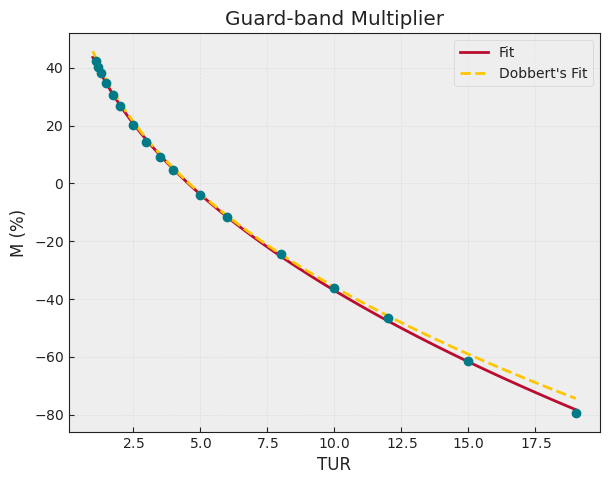

In [7]:
# Figure 4 in Dobbert
xx = np.linspace(1,19)
plt.plot(xx, fitfunc(xx, a, b, c)*100, ls='-', label='Fit', color='C1')
plt.plot(xx, fitfunc(xx, 1.04, 0.38, 0.54)*100, ls='--', label="Dobbert's Fit", color='C2')
plt.plot(turlist, M*100, marker='o', ls='', color='C0')

plt.xlabel('TUR')
plt.ylabel('M (%)')
plt.title('Guard-band Multiplier')
plt.legend();

Print out our version of Dobbert's Table 2.

In [8]:
table = '| TUR | ITP for Max PFA | Max PFA | M x 100% |\n'
table += '|----|-----------------|---------|----------|\n'
for tur, maxitp, maxpfa, m100 in zip(turlist, itpmax, pfamax, M*100):
    table += f'| {tur} | {maxitp*100:.2f} % | {maxpfa*100:.3f} % | {m100:.2f} % |\n'
Markdown(table)

| TUR | ITP for Max PFA | Max PFA | M x 100% |
|----|-----------------|---------|----------|
| 1.1 | 57.32 % | 6.847 % | 42.33 % |
| 1.2 | 58.05 % | 6.392 % | 40.26 % |
| 1.3 | 58.69 % | 5.993 % | 38.30 % |
| 1.5 | 59.76 % | 5.330 % | 34.65 % |
| 1.75 | 60.80 % | 4.682 % | 30.53 % |
| 2.0 | 61.62 % | 4.175 % | 26.79 % |
| 2.5 | 62.81 % | 3.432 % | 20.18 % |
| 3.0 | 63.64 % | 2.914 % | 14.39 % |
| 3.5 | 64.25 % | 2.532 % | 9.21 % |
| 4.0 | 64.72 % | 2.238 % | 4.48 % |
| 5.0 | 65.39 % | 1.817 % | -3.97 % |
| 6.0 | 65.85 % | 1.529 % | -11.46 % |
| 8.0 | 66.43 % | 1.161 % | -24.58 % |
| 10.0 | 66.79 % | 0.936 % | -36.12 % |
| 12.0 | 67.03 % | 0.784 % | -46.67 % |
| 15.0 | 67.27 % | 0.630 % | -61.33 % |
| 19.0 | 67.48 % | 0.500 % | -79.60 % |
